# Machine Learning Neural Network (ECG prediction)

## Introduction
In this project, I explore the application of machine learning to analyze electrocardiogram (ECG) data. ECGs, crucial for diagnosing heart conditions, present an opportunity for enhanced analysis through machine learning to improve accuracy and efficiency.

I will utilize ECG recordings and expert annotations from datasets in CSV and TXT format; CSV file will contain modified limb lead II (MLII) and v5, TXT file will contain the time stamp of the rpeaks and the type of heartbeat (normal, abnormal). These resources are essential for training and evaluating a machine learning model to identify R-peaks and classify the normality of heartbeats, key indicators of heart health.

My objectives:
- **Investigate Machine Learning Applications:** Apply machine learning models, specifically using Dense and Dropout layers, to ECG data.
- **Detect R-Peaks:** Use machine learning for accurate R-peak detection in ECG signals.
- **Classify Heartbeat Normality:** Develop a model to classify heartbeat normality, identifying potential cardiac abnormalities.

This project aims to explore the potential of machine learning in ECG analysis.

libraries imported for the project:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F 
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Data Collection and Preprocessing

### Data Collection
The data is sourced from [MIT-BIH Arrhythmia Database](https://www.physionet.org/content/mitdb/1.0.0/)

### Data Loading

In [2]:
# listing file path

file_paths = [
    '100', '101', '102', '103', '104',
    '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115',
    '116', '117', '118', '118', '119',
    '121', '122', '123', '124', '200',
    '201', '202', '203', '205', '207',
    '208', '209', '210', '212', '213',
    '214', '215', '217', '219', '220', 
    '221', '222', '223', '228', '230',
    '231'
]

csv_list = []
txt_list = []

for file_path in file_paths:
    csv_df = pd.read_csv(f"data/{file_path}.csv")
    txt_df = pd.read_table(f"data/{file_path}annotations.txt", delimiter = '\t')
    
    csv_df.columns = ['samp_num', 'MLII', 'V5']
    txt_df.columns = ['6', 'RA'] # RA stands for Rhythm annotation
    
    csv_list.append(csv_df)
    txt_list.append(txt_df)

# check if the list are of the same length
print(f"csv: {len(csv_list)}\ntxt: {len(txt_list)}")

csv: 46
txt: 46


## Exploratory Data Analysis (EDA) 
Through visualizations and statistical summaries, EDA helps uncover underlying structures, informs the choice of appropriate models, and guides hypothesis formulation, ensuring a deeper insight into the data's nature. This process is invaluable in projects involving complex datasets, such as ECG data, where identifying key features like R-peaks or heartbeat normality can significantly impact model performance and accuracy.

Raw data from the csv file:

In [3]:
csv_list[0].head()

samp_num  MLII    V5
0         0   995  1011
1         1   995  1011
2         2   995  1011
3         3   995  1011
4         4   995  1011

Raw data from the txt file:

In [4]:
txt_list[0].head()

6   RA
0      0:00.050       18     +    0    0    0   (N
1      0:00.214       77     N    0    0    0  NaN
2      0:01.028      370     N    0    0    0  NaN
3      0:01.839      662     N    0    0    0  NaN
4      0:02.628      946     N    0    0    0  NaN

For the TXT file, the column `6` is named such that it has 6 columns, originally it is `Time Sample # Type Sub Chan Num`, but due to the way the data is structured I have to reorganise it.

The information under the `#` and `Type` columns are important as it is where the Rpeak is and the classification of the heartbeat; I will merge the two dataframe into one by adding `#` and `Type` into the first dataframe.

I realised for TXT file, there are different types of symbols for `Type` so i want to compile them into a list such that it will be easier to normalise it later on with all the datasets.

In [5]:
symbols = []
for df in txt_list:
    for index, row in df.iterrows():
        symbol = df['6'][index].split()[2]
        if symbol not in symbols:
            symbols.append(symbol)
print(symbols)

['+', 'N', 'A', 'V', '~', '|', 'Q', '/', 'f', 'x', 'F', 'j', 'L', 'a', 'J', 'R', '[', '!', ']', 'E', 'S', '"', 'e']


According to the database [website](https://www.physionet.org/files/mitdb/1.0.0/mitdbdir/intro.htm) each symbol means something. Here are the examples:

| Symbol | Meaning                                      |
|--------|----------------------------------------------|
| · or N | Normal beat                                  |
| L      | Left bundle branch block beat                |
| R      | Right bundle branch block beat               |
| A      | Atrial premature beat                        |
| a      | Aberrated atrial premature beat              |
| J      | Nodal (junctional) premature beat            |
| S      | Supraventricular premature beat              |
| V      | Premature ventricular contraction            |
| F      | Fusion of ventricular and normal beat        |
| [      | Start of ventricular flutter/fibrillation    |
| !      | Ventricular flutter wave                     |
| ]      | End of ventricular flutter/fibrillation      |
| e      | Atrial escape beat                           |
| j      | Nodal (junctional) escape beat               |
| E      | Ventricular escape beat                      |
| /      | Paced beat                                   |
| f      | Fusion of paced and normal beat              |
| x      | Non-conducted P-wave (blocked APB)           |
| Q      | Unclassifiable beat                          |
| \|      | Isolated QRS-like artifact                  |

Function to merge both dataframes to easily train the machine learning neural network:

In [6]:
def add_rpeak_normality_columns(df, ref_df):
    refRpeak = []
    refNormal = []

    # Extract the 'rpeak' and 'type'
    for index, row in ref_df.iterrows():
        if ref_df['6'][index].split()[2] in symbols:
            refRpeak.append(ref_df['6'][index].split()[1]) 
            refNormal.append(ref_df['6'][index].split()[2]) 

    # Ensuring elements of refRpeak are integers
    refRpeak = [int(val) for val in refRpeak]

    # Create new columns in the DataFrame
    df['rpeak'] = 0
    df['normality'] = 0

    # Set 'rpeak' column values to 1 where samp_num is in refRpeak
    df.loc[df['samp_num'].isin(refRpeak), 'rpeak'] = 1

    # Create a mapping of symbol to integer for normality
    symbol_to_int = {symbol: idx for idx, symbol in enumerate(symbols)}

    # Assuming 'samp_num' matches with 'refRpeak' order
    for rpeak, normal in zip(refRpeak, refNormal):
        if normal in symbol_to_int:
            df.loc[df['samp_num'] == rpeak, 'normality'] = symbol_to_int[normal]
        else:
            print(f'{normal} not found in symbols')
            
    return df

Merging the dataframes:

In [7]:
df_list = []

for i, csv in enumerate(csv_list):
    for j, txt in enumerate(txt_list):
        if (i == j):
            df_list.append(add_rpeak_normality_columns(csv, txt))

print('completed')

completed


Visual of merged dataframe:

In [8]:
df_list[0].head()

samp_num  MLII    V5  rpeak  normality
0         0   995  1011      0          0
1         1   995  1011      0          0
2         2   995  1011      0          0
3         3   995  1011      0          0
4         4   995  1011      0          0

## Exploratory Data Analysis (EDA)
Through visualizations and statistical summaries, EDA helps uncover underlying structures, informs the choice of appropriate models, and guides hypothesis formulation, ensuring a deeper insight into the data's nature. This process is invaluable in projects as it involves complex datasets, such as ECG data, where identifying key features like R-peaks or heartbeat normality can significantly impact model performance and accuracy.

### Basic Information
The first merged dataframe will be used as an example for EDA.

Number of merged dataframe:

In [9]:
print(len(df_list))

46


Basic information about the merged dataset:

In [10]:
df_list[0].head()

samp_num  MLII    V5  rpeak  normality
0         0   995  1011      0          0
1         1   995  1011      0          0
2         2   995  1011      0          0
3         3   995  1011      0          0
4         4   995  1011      0          0

In [11]:
df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   samp_num   650000 non-null  int64
 1   MLII       650000 non-null  int64
 2   V5         650000 non-null  int64
 3   rpeak      650000 non-null  int64
 4   normality  650000 non-null  int64
dtypes: int64(5)
memory usage: 24.8 MB


In [12]:
df_list[0].describe()

samp_num           MLII             V5          rpeak  \
count  650000.000000  650000.000000  650000.000000  650000.000000   
mean   324999.500000     962.740205     985.793114       0.003498   
std    187638.981824      38.639938      29.642668       0.059044   
min         0.000000     481.000000     531.000000       0.000000   
25%    162499.750000     946.000000     971.000000       0.000000   
50%    324999.500000     957.000000     983.000000       0.000000   
75%    487499.250000     970.000000     995.000000       0.000000   
max    649999.000000    1311.000000    1269.000000       1.000000   

           normality  
count  650000.000000  
mean        0.003551  
std         0.060406  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         3.000000

### Check for Missing Values

In [13]:
for df in df_list:
    print(df.isnull().sum())

samp_num     0
MLII         0
V5           0
rpeak        0
normality    0
dtype: int64
samp_num     0
MLII         0
V5           0
rpeak        0
normality    0
dtype: int64
samp_num     0
MLII         0
V5           0
rpeak        0
normality    0
dtype: int64
samp_num     0
MLII         0
V5           0
rpeak        0
normality    0
dtype: int64
samp_num     0
MLII         0
V5           0
rpeak        0
normality    0
dtype: int64
samp_num     0
MLII         0
V5           0
rpeak        0
normality    0
dtype: int64
samp_num     0
MLII         0
V5           0
rpeak        0
normality    0
dtype: int64
samp_num     0
MLII         0
V5           0
rpeak        0
normality    0
dtype: int64
samp_num     0
MLII         0
V5           0
rpeak        0
normality    0
dtype: int64
samp_num     0
MLII         0
V5           0
rpeak        0
normality    0
dtype: int64
samp_num     0
MLII         0
V5           0
rpeak        0
normality    0
dtype: int64
samp_num     0
MLII         0
V5

### Distribution of Key Features

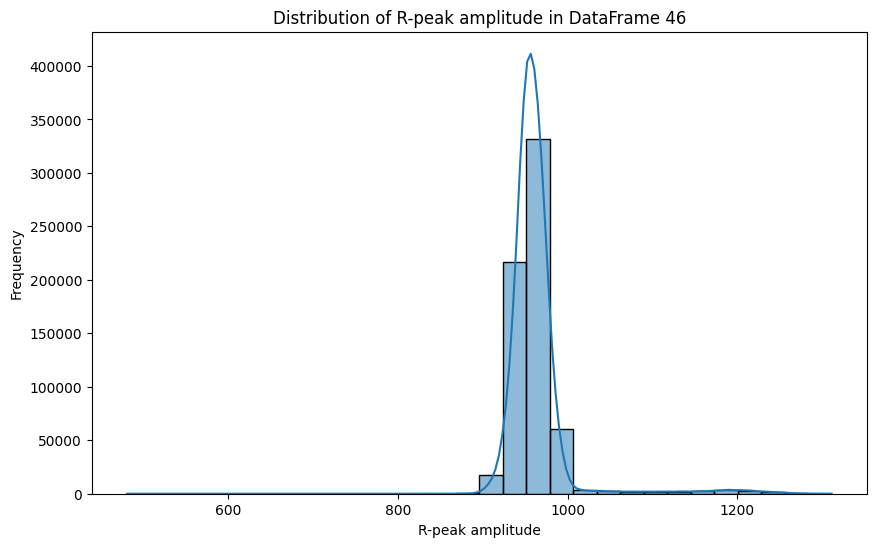

In [14]:
df = df_list[0]
plt.figure(figsize=(10, 6))
sns.histplot(df['MLII'], bins=30, kde=True)
plt.title(f'Distribution of R-peak amplitude in DataFrame {i+1}')
plt.xlabel('R-peak amplitude')
plt.ylabel('Frequency')
plt.show()

### Identifying Outliers

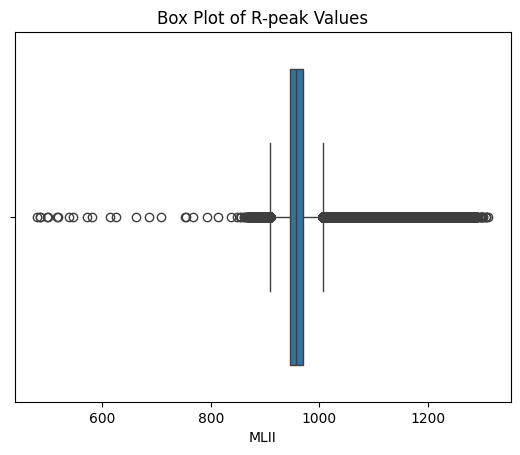

In [15]:
# Box plot for a numerical column
sns.boxplot(x=df['MLII'])
plt.title('Box Plot of R-peak Values')
plt.show()

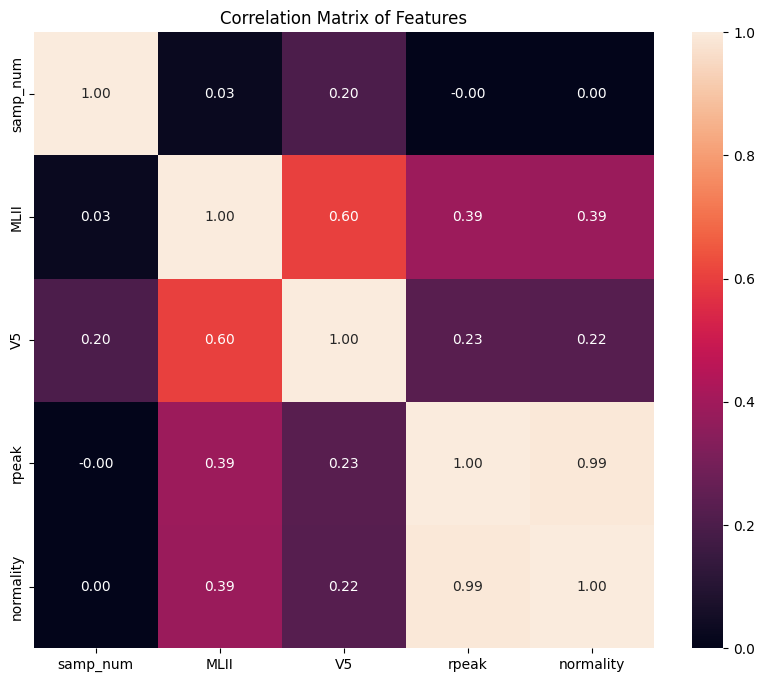

In [16]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

## Model Building (Markdown + Code)
### Model Architecture

The architecture of the model, `ECGModel`, is designed to address the dual objectives of detecting R-peaks and classifying heartbeat normality from ECG signals. The model consists of the following components:

- **LSTM Layer:** The core of the model is an LSTM layer, chosen for its ability to capture temporal dependencies in time-series data, such as ECG signals. This layer takes inputs of size `input_size` and transforms them through `hidden_size` units to capture the sequential characteristics of the data effectively.

- **Linear Layers for Output:** Following the LSTM, the model branches into two separate linear layers:
    - `fc_rpeak`: A linear layer with a single output unit, followed by a sigmoid activation function for binary classification of R-peaks. This setup is tailored for the binary nature of R-peak detection, indicating the presence or absence of R-peaks in the ECG signal.
    - `fc_normality`: Another linear layer that maps to `num_classes_normality` output units, followed by a softmax activation function for multi-class classification. This structure is designed to classify the normality of heartbeats into several predefined categories, accommodating the multi-class nature of heartbeat normality assessment.

- **Dropout Layer:** Following the LSTM layer, a dropout layer with a rate of 0.8 is introduced to mitigate overfitting. By randomly deactivating half of the units in the LSTM output during training, the model is encouraged to learn redundant representations, enhancing its generalization capabilities. This is particularly important in complex models trained on datasets like ECG signals, where the risk of overfitting to the training data is significant.


The choice of a sigmoid function for R-peak detection reflects the binary classification task, while the softmax function for normality classification suits the multi-class problem. The LSTM layer's ability to process sequential data makes it an ideal choice for analyzing ECG signals, which are inherently time-series in nature.


In [27]:
class ECGModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes_normality):
        super(ECGModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.8)  # Dropout layer
        self.fc_rpeak = nn.Linear(hidden_size, 1)  # For rpeak detection
        self.fc_normality = nn.Linear(hidden_size, num_classes_normality)  # For normality classification

    def forward(self, x):
        # LSTM layer
        x, _ = self.lstm(x)
        
        # Applying dropout after LSTM output
        x = self.dropout(x)
        
        # Output layers
        rpeak_output = torch.sigmoid(self.fc_rpeak(x))  # Sigmoid for binary classification
        normality_output = F.softmax(self.fc_normality(x), dim=1)  # Softmax for multi-class classification

        return rpeak_output, normality_output

### Data Preparation
Before training the model, it's essential to prepare the ECG data. This involves selecting the relevant features (`MLII`, `V5`), targets (`rpeak`, `normality`), converting the data into PyTorch tensors, and splitting the dataset into training and test sets. This process ensures that the model learns from a diverse range of examples and is evaluated on unseen data to check its generalization ability.

In [28]:
X = df_list[0][['MLII', 'V5']].values
y_rpeak = df_list[0]['rpeak'].values
y_normality = df_list[0]['normality'].values

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float)
y_rpeak_tensor = torch.tensor(y_rpeak, dtype=torch.float)
y_normality_tensor = torch.tensor(y_normality, dtype=torch.long)

# Combine the tensors into a single dataset
dataset = TensorDataset(X_tensor, y_rpeak_tensor, y_normality_tensor)

# Calculate the size of the test dataset (20% of the total data)
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size

# Split the dataset into training and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create a DataLoader for the training set to enable shuffling and batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Not shuffling the test set, but still use a DataLoader for batching
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model Training Setup
After defining the `ECGModel` and preparing the data, the next step is to set up the model for training. This includes specifying the loss functions for both tasks (rpeak detection and normality classification), choosing an optimizer, and defining the training loop. The training process iteratively updates the model weights to minimize the loss, improving its accuracy in detecting R-peaks and classifying heartbeat normality.

In [29]:
# Calculate the number of unique classes for normality
num_classes_normality = len(torch.unique(y_normality_tensor))

# Initialize the model with the correct number of classes
model = ECGModel(input_size=2, hidden_size=10, num_classes_normality=num_classes_normality)

criterion_rpeak = torch.nn.BCELoss()  # Binary Cross-Entropy Loss for rpeak
criterion_normality = torch.nn.CrossEntropyLoss()  # Cross-Entropy Loss for normality
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training Loop
The training loop is where the model learns from the data. In each epoch, the model makes predictions, computes the loss, and updates its parameters. Monitoring the loss helps in understanding how well the model is learning over time. Adjustments to the learning rate, model architecture, or data preparation might be necessary based on the observed training dynamics.

In [33]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for X_batch, y_rpeak_batch, y_normality_batch in progress_bar:
        # Your training code here
        # Update the progress bar description
        progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / (len(train_loader.dataset)/train_loader.batch_size)}')
        # Forward pass
        rpeak_pred, normality_pred = model(X_batch)
        
        # Compute loss
        loss_rpeak = criterion_rpeak(rpeak_pred.squeeze(), y_rpeak_batch)
        loss_normality = criterion_normality(normality_pred, y_normality_batch)
        loss = loss_rpeak + loss_normality  # Combine losses
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch+1) % 10 == 0:  # Print average loss every 10 epochs
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss / len(train_loader)}')
        

Epoch 1/10, Loss: 0.7703283522936014: 100%|█| 16250/16250 [00:58<00:00, 276.33it
Epoch 2/10, Loss: 0.770252122416863: 100%|█| 16250/16250 [00:58<00:00, 276.53it/
Epoch 3/10, Loss: 0.7702521487896259: 100%|█| 16250/16250 [00:58<00:00, 278.13it
Epoch 4/10, Loss: 0.770247130214251: 100%|█| 16250/16250 [00:58<00:00, 276.93it/
Epoch 5/10, Loss: 0.7702339441922995: 100%|█| 16250/16250 [00:58<00:00, 276.78it
Epoch 6/10, Loss: 0.7702523808039151: 100%|█| 16250/16250 [00:58<00:00, 277.14it
Epoch 7/10, Loss: 0.7702484418979058: 100%|█| 16250/16250 [00:58<00:00, 276.49it
Epoch 8/10, Loss: 0.7702376376995673: 100%|█| 16250/16250 [00:58<00:00, 277.50it
Epoch 9/10, Loss: 0.7702551272979149: 100%|█| 16250/16250 [00:58<00:00, 278.25it
Epoch 10/10, Loss: 0.7702347623384916: 100%|█| 16250/16250 [00:58<00:00, 277.91i

Epoch [10/10], Average Loss: 0.7702940040845138


## Model Evaluation
After training our ECG model, which is designed to detect R-peaks and classify heartbeat normality from ECG signals, the next crucial step is evaluating its performance on unseen data. The evaluation phase is essential for understanding how well our model generalizes beyond the training data, providing insights into its potential real-world applicability.

### Loss Evaluation

The first part of our evaluation involves calculating the model's loss on the test set. This loss gives us a direct measure of how well the model's predictions align with the actual labels across both tasks: R-peak detection and heartbeat normality classification.

In [37]:
model.eval()  # Set the model to evaluation mode

total_loss = 0
# No gradient computation for evaluation
with torch.no_grad():
    for X_batch, y_rpeak_batch, y_normality_batch in test_loader:
        rpeak_pred, normality_pred = model(X_batch)
        
        # Compute the losses for both tasks
        loss_rpeak = criterion_rpeak(rpeak_pred.squeeze(), y_rpeak_batch)
        loss_normality = criterion_normality(normality_pred, y_normality_batch)
        
        # Combine the losses for a total loss
        total_loss += (loss_rpeak + loss_normality).item()

# Calculate the average loss over all test batches
average_loss = total_loss / len(test_loader)
print(f"Average Test Loss: {average_loss}")

Average Test Loss: 0.771124650332953


### Accuracy Evaluation

While loss provides a measure of the model's error, accuracy offers a more intuitive understanding of its performance, especially in classification tasks.

In [39]:
model.eval()  # Set the model to evaluation mode
rpeak_accuracy_list = []
normality_accuracy_list = []

with torch.no_grad():
    for X_batch, y_rpeak_batch, y_normality_batch in test_loader:
        # Forward pass with the test data
        rpeak_pred, normality_pred = model(X_batch)
        
        # Evaluate model performance on this batch
        rpeak_accuracy, normality_accuracy = evaluate_model_performance(rpeak_pred, normality_pred, y_rpeak_batch, y_normality_batch)
        
        # Store the accuracies for each batch
        rpeak_accuracy_list.append(rpeak_accuracy)
        normality_accuracy_list.append(normality_accuracy)

# Calculate average accuracies across all test batches
avg_rpeak_accuracy = sum(rpeak_accuracy_list) / len(rpeak_accuracy_list)
avg_normality_accuracy = sum(normality_accuracy_list) / len(normality_accuracy_list)

print(f"Average R-Peak Detection Accuracy: {avg_rpeak_accuracy * 100:.2f}%")
print(f"Average Heartbeat Normality Classification Accuracy: {avg_normality_accuracy * 100:.2f}%")

Average R-Peak Detection Accuracy: 99.64%
Average Heartbeat Normality Classification Accuracy: 99.64%


### Insights and Next Steps
The combined evaluation of average loss and accuracy across the test set furnishes a holistic view of the model's performance. It not only highlights how closely the model's predictions match the actual labels but also reveals how effectively it distinguishes between different classes in a multi-class setting.

Low loss and high accuracy across both tasks indicate a well-performing model that generalizes well to unseen data.
Discrepancies between loss and accuracy or between the performance on different tasks may suggest areas for improvement, such as model architecture adjustments, hyperparameter tuning, or addressing data imbalance.
This evaluation framework sets the stage for iterative model refinement, guiding efforts to enhance model performance and, ultimately, its utility in real-world applications for ECG signal analysis.

## Results and Discussion (Markdown + Code)

Results (Markdown + Code):
Present key findings, supported by code cells that output results, visualizations, etc.
Discussion (Markdown): Interpret the results, discuss any limitations, and how the model could be improved.

## Conclusion and Future Work (Markdown)

Summarize your findings, the implications of your work, and any potential future directions for this research.

## References (Markdown)

List all references, including articles, books, and online resources, that were cited or used for code in the project.